# COVID-19 en France

Kelun Chai, Djaber Solimani

In [1]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import sys
import os
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
#import geopandas as gpd

try:
    from data.France_data import *
    from visual.Set_plot import *
    from data.World_data import *
    from model.sir import *
except ImportError:
    print('Import failed.')

set_style()
set_pandas_display_options()

## Données hospitalières relatives à l'épidémie de COVID-19
- Les données hospitalières relatives à l'épidémie du COVID-19 par département et sexe du patient.

In [2]:
data_hospitaliere = load_hospitaliere()
meta_hospitaliere = load_meta_hospitaliere()
print("Description:")
display(meta_hospitaliere)

Description:


,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,sexe,integer,Sexe,Sex,0
2,jour,string($date),Date de notification,Date of notice,18/03/2020
3,hosp,integer,Nombre de personnes actuellement hospitalisées,Number of people currently hospitalized,2
4,rea,integer,Nombre de personnes actuellement en réanimation ou soins intensifs,Number of people currently in resuscitation or critical care,0
5,rad,integer,Nombre cumulé de personnes retournées à domicile,Total amount of patient that returned home,1
6,dc,integer,Nombre cumulé de personnes décédées à l'hôpital,Total amout of deaths at the hospital,0


In [3]:
data_hospitaliere.head(5)

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


- Situation globale en France

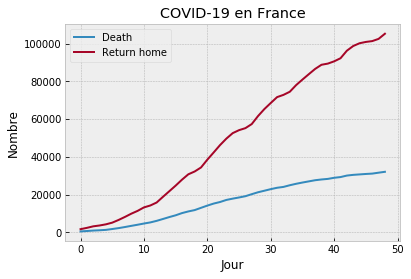

In [4]:
time=data_hospitaliere['jour'].unique()
# display(data_hospitaliere.loc[data_hospitaliere.jour==time[0],['dep','jour','sexe','dc']])
# print(data_hospitaliere.loc[data_hospitaliere.jour==time[0],['dc']].sum())
def death_by_day():
    death=[]
    for i in time:
        num=data_hospitaliere.loc[data_hospitaliere.jour==i,['dc']].sum()
        death.append(num)
    return death

def rad_by_day():
    rad=[]
    for i in time:
        num=data_hospitaliere.loc[data_hospitaliere.jour==i,['rad']].sum()
        rad.append(num)
    return rad
    
def show_global():
    x=np.arange(len(time))
    y=death_by_day()
    y1=rad_by_day()
    plt.plot(x,y,label="Death")
    plt.plot(x,y1,label="Return home")
    plt.title("COVID-19 en France")
    plt.legend()
    plt.xlabel('Jour')
    plt.ylabel("Nombre")
    plt.show()

show_global()

/home/klchai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


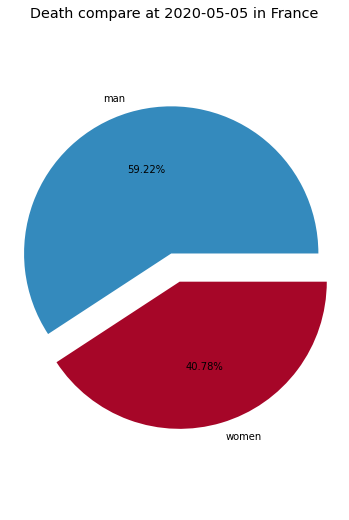

In [59]:
today = data_hospitaliere.loc[data_hospitaliere.jour=="2020-05-05"]
def death_man():
    death=[]
    num=today.loc[today.sexe==1,['dc']].sum()
    death.append(num)
    return death

def death_woman():
    death=[]
    num=today.loc[today.sexe==2,['dc']].sum()
    death.append(num)
    return death

man=death_man()
women=death_woman()
plt.figure(figsize=(6,9))
labels=['man','women']
sizes=[man,women]
explode=(0.2,0)
patches,text1,text2 = plt.pie(sizes, labels=labels, explode=explode,autopct = '%3.2f%%') 
plt.title("Death compare at 2020-05-05 in France")
plt.axis('equal')
plt.show()

- Situation à Paris

In [31]:
df_paris = data_hospitaliere[data_hospitaliere.dep=='75']

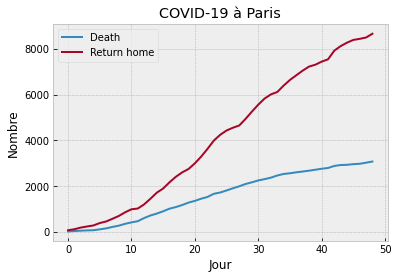

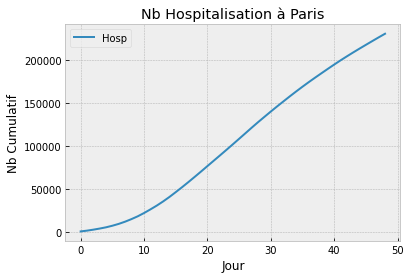

In [32]:
def death_in_paris():
    death=[]
    for i in time:
        num=df_paris.loc[df_paris.jour==i,['dc']].sum()
        death.append(num)
    return death

def rad_in_paris():
    rad=[]
    for i in time:
        num=df_paris.loc[df_paris.jour==i,['rad']].sum()
        rad.append(num)
    return rad

def hosp_in_paris():
    hosp=[]
    for i in time:
        num=df_paris.loc[df_paris.jour==i,['hosp']].sum()
        hosp.append(num)
    cum_hosp = np.array(hosp).cumsum()
    return cum_hosp

def show_global():
    x=np.arange(len(time))
    y=death_in_paris()
    y1=rad_in_paris()
    plt.plot(x,y,label="Death")
    plt.plot(x,y1,label="Return home")
    plt.title("COVID-19 à Paris")
    plt.legend()
    plt.xlabel("Jour")
    plt.ylabel("Nombre")
    plt.show()

def show_hosp_paris():
    x=np.arange(len(time))
    y=hosp_in_paris()
    plt.plot(x,y,label="Hosp")
    plt.title("Nb Hospitalisation à Paris")
    plt.legend()
    plt.xlabel("Jour")
    plt.ylabel("Nb Cumulatif")
    plt.show()
    
show_global()
show_hosp_paris()

### Afficher sur la carte

In [33]:
carte = gpd.read_file('visual/departements-version-simplifiee.geojson')

In [34]:
data = load_hospitaliere_etablissements()
df_today = data.loc[data.jour=="2020-05-05",['dep','nb']]
meta = load_meta_hospitaliere_etablissements()
meta.head(3)

,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,jour,string($date),Date de notification,Date of notice,18/03/2020
2,nb,integer,Nombre cumulé de services hospitaliers ayant déclaré au moins un cas,Total amount of hospital services reporting at least one case,1


In [35]:
data_merge = carte.merge(df_today, left_on='code', right_on='dep', suffixes=('','_y')).drop('dep',axis=1)
# data_merge.head(5)

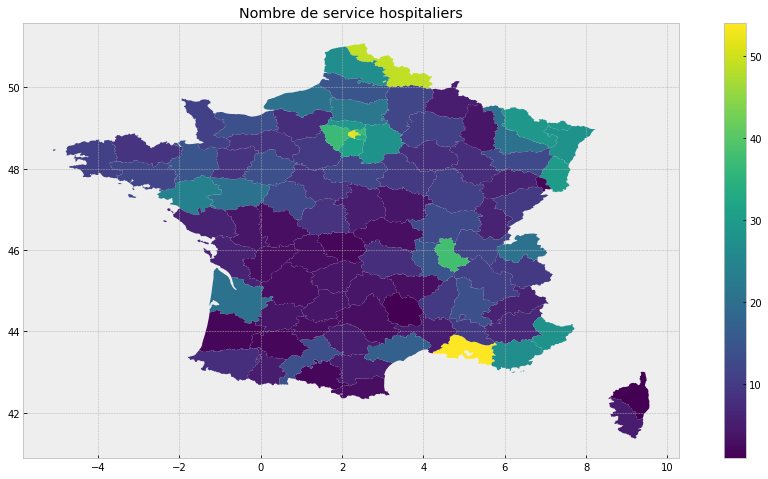

In [36]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16, 8)
data_merge.plot(column='nb',ax=ax,legend=True)
plt.title("Nombre de service hospitaliers")
plt.show()

## Données relatives aux tests de dépistage de COVID-19 réalisés en laboratoire de ville

In [37]:
data_tests = load_tests_daily()
meta_tests = load_meta_tests()
tranches_age = load_tranches_age()
display(meta_tests)
display(tranches_age)

/home/klchai/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Colonne,Type,Description_FR,Description_EN,Exemple
0,dep,integer,Département,Department,1
1,jour,string($date),Date de notification,Date of notice,10/03/2020
2,clage_covid,string,Tranche d'âge des patients,Age group of patients,A
3,nb_test,integer,Nombre de tests pour recherche de SARS-CoV-2,Number of tests for SARS-CoV-2 search,1
4,nb_pos,integer,Nombre de tests positifs pour recherche de SARS-CoV-2,Number of positive tests for SARS-CoV-2,1
5,tx_pos,integer,Taux de tests positif pour recherche de SARS-CoV-2,Positive test rate for SARS-CoV-2 search,2
6,nb_test_h,integer,Nombre de tests pour recherche de SARS-CoV-2 - Hommes,Number of tests for SARS-CoV-2 search - Male,1
7,nb_pos_h,integer,Nombre de tests positifs pour recherche de SARS-CoV-2 - Hommes,Number of positive tests for SARS-CoV-2 - Male,1
8,nb_test_f,integer,Nombre de tests pour recherche de SARS-CoV-2 - Femmes,Number of tests for SARS-CoV-2 search - Female,1
9,nb_pos_f,integer,Nombre de tests positifs pour recherche de SARS-CoV-2 - Femmes,Number of positive tests for SARS-CoV-2 - Female,1


,Code tranches d'age,Unnamed: 1
0,0,tous âges
1,A,moins de 15 ans
2,B,15-44 ans
3,C,45-64 ans
4,D,65-74 ans
5,E,75 et plus


In [40]:
# data_tests.loc[data_tests.dep==75]

,dep,jour,clage_covid,nb_test,nb_pos,nb_test_h,nb_pos_h,nb_test_f,nb_pos_f
1652400,75,2020-03-10,0,1,1,1,1,0,0
1652401,75,2020-03-10,A,0,0,0,0,0,0
1652402,75,2020-03-10,B,0,0,0,0,0,0
1652403,75,2020-03-10,C,0,0,0,0,0,0
1652404,75,2020-03-10,D,1,1,1,1,0,0
1652405,75,2020-03-10,E,0,0,0,0,0,0
1652406,75,2020-03-11,0,11,2,4,1,7,1
1652407,75,2020-03-11,A,1,0,0,0,1,0
1652408,75,2020-03-11,B,8,2,3,1,5,1
1652409,75,2020-03-11,C,1,0,0,0,1,0


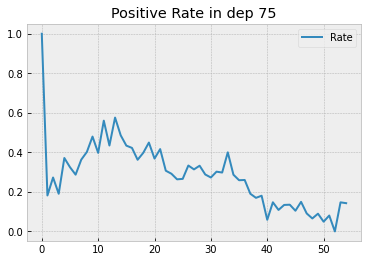

In [39]:
date=data_tests['jour'].unique()[:57]
# print(date)
def pos_rate_dep(num):
    data = data_tests.loc[(data_tests.dep==num)&(data_tests.clage_covid=="0"),['jour','nb_test','nb_pos']]
    pos_rate=[]
    for i in date:
        nb_test=data.loc[data.jour==i,['nb_test']].sum()
        nb_pos=data.loc[data.jour==i,['nb_pos']].sum()
        rate=np.divide(nb_pos,nb_test)
        pos_rate.append(rate)
    return pos_rate

y=pos_rate_dep(75)
plt.title("Positive Rate in dep 75")
plt.plot(y,label="Rate")
plt.legend()
plt.show()

## SIR Model

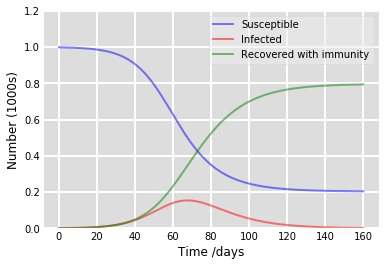

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

### SIR Model training on Italy Data

In [2]:
clean()

/home/klchai/workspace/ML_COVID-19/data/World_data.py:53: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
/home/klchai/workspace/ML_COVID-19/data/World_data.py:55: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']


In [5]:
uk = load_UK()
uk.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
9,2020-01-31,United Kingdom,2,0,0.0,2.0,2,0,0
10,2020-02-01,United Kingdom,2,0,0.0,2.0,0,0,0
11,2020-02-02,United Kingdom,2,0,0.0,2.0,0,0,0
12,2020-02-03,United Kingdom,2,0,0.0,2.0,0,0,0
13,2020-02-04,United Kingdom,2,0,0.0,2.0,0,0,0


In [6]:
italy = load_italy()
italy.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
9,2020-01-31,Italy,2,0,0.0,2.0,2,0,0
10,2020-02-01,Italy,2,0,0.0,2.0,0,0,0
11,2020-02-02,Italy,2,0,0.0,2.0,0,0,0
12,2020-02-03,Italy,2,0,0.0,2.0,0,0,0
13,2020-02-04,Italy,2,0,0.0,2.0,0,0,0


In [7]:
t=range(italy.shape[0])
N = 60_485_321
I=italy["Confirmed"].to_numpy()
sir=SIRModel()
params=sir.fit(t,N,I)
print("Params:",params)
S_n, I_n, R_n = sir.res(t,N,I)

/home/klchai/anaconda3/envs/algo/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/klchai/workspace/ML_COVID-19/model/sir.py:16: RuntimeWarning: overflow encountered in double_scalars
  dSdt = -beta * S * I / N
/home/klchai/workspace/ML_COVID-19/model/sir.py:17: RuntimeWarning: overflow encountered in double_scalars
  dIdt = beta * S * I / N - gamma * I


Params: [1.17598871 1.05819925]


In [9]:
def plottest(t, I, test):
    f, ax = plt.subplots(1,1)
    ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t,test["Confirmed"],'k', alpha=0.7, lw=2, label='Really infected')
    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

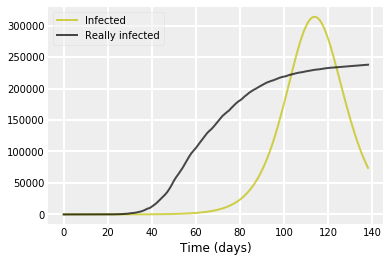

In [10]:
plottest(t, I_n, italy)

### SEIR model

In [12]:
df_italy = load_italy()

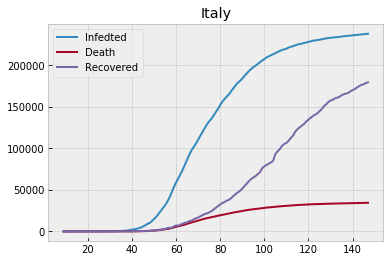

In [13]:
plt.plot(df_italy["Confirmed"],label="Infedted")
plt.plot(df_italy["Deaths"],label="Death")
plt.plot(df_italy["Recovered"],label="Recovered")
plt.legend()
plt.title("Italy")
plt.show()

In [14]:
def deriv_SEIR(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [15]:
N = 60_485_321
D = 10.0 # infections lasts 10 days
gamma = 1.0 / D
delta = 1.0 / 3.0  # incubation period of three days
R_0 = 5.0
beta = R_0 * gamma
S0, E0, I0, R0 = N-2, 2, 0, 0  # initial conditions: one exposed, rest susceptible
t = range(df_italy.shape[0])
y0 = S0, E0, I0, R0

In [16]:
# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv_SEIR, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

/home/klchai/anaconda3/envs/algo/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Parameters: beta 1.17587016384075, gamma 1.0529088316296409, delta 24.336540296012746


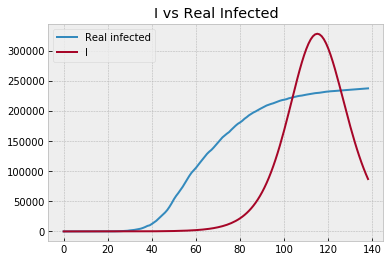

In [18]:
def fit(t, bt, gma, delta):
    res = odeint(deriv_SEIR, y0, t, args=(N, bt, gma, delta))
    S, E, I, R = res.T
    return I

real_infected = df_italy["Confirmed"].to_numpy()
real_recov = df_italy["Recovered"].to_numpy()
params, pcov = curve_fit(fit, t, real_infected)
print("Parameters: beta {0}, gamma {1}, delta {2}".format(params[0],params[1],params[2]))

b,g,l=params
ret_SEIR = odeint(deriv_SEIR, y0, t, args=(N, b, g, l))
S_n, E_n, I_n, R_n = ret_SEIR.T

plt.plot(real_infected,label="Real infected")
plt.plot(I_n,label="I")
plt.legend()
plt.title("I vs Real Infected")
plt.show()

In [21]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t,df_italy["Confirmed"].to_numpy(),'k', alpha=0.7, lw=2, label='Really infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    plt.show();

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))
  
    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        ax.set_ylabel('Number (1000s)')
        ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

        ax2.set_xlabel('Time (days)')
        ax2.title.set_text('fatality rate over time')
        ax.set_ylabel('Number (1000s)')
        ax.set_ylim(0,1.2)
        ax2.yaxis.set_tick_params(length=0)
        ax2.xaxis.set_tick_params(length=0)
        ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax2.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    plt.show()

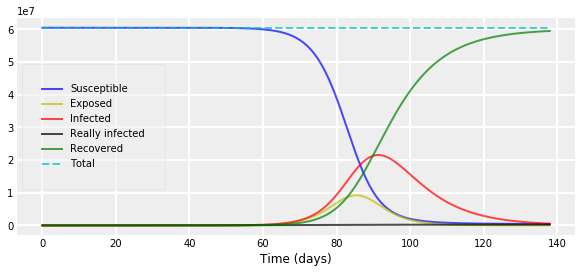

In [24]:
plotseird(t, S, E, I, R)

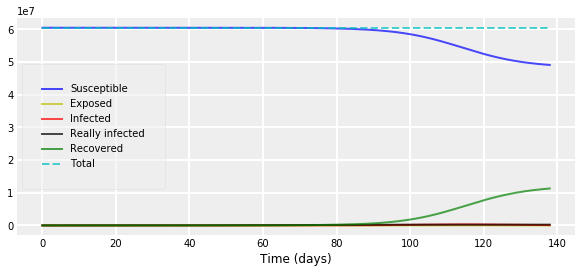

In [27]:
t_n = range(139)
plotseird(t_n, S_n, E_n, I_n, R_n)

### SEIRD model